# Bunch longitudinal distribution --> comparison with proton data

Having a look to the streak camera data recorded on the 2nd of November to understand if the proton beam is gaussian-, cos^2- or what- distributed

**THIS IS THE RIGHT FILE**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import pandas as pnd
import glob
import os
import h5py

# Import the data

In [ ]:
if os.path.isfile('data_streak_camera_AM.pkl'):#here we go again, just load
    data = pnd.read_pickle('data_streak_camera_AM.pkl')
else:
    dataFile = "../Measurements-with-protons/streak-camera-data/20190221_161916_corrTimeAxis.mat"
    

In [279]:
f = h5py.File(dataFile,'r')
row_n = f['Data']['Protons']['BCT_bunchIntensity'].shape[0]

# init
BCT_bunchIntensity = []
BCT_timeStamp_ms = []
SCtimeAxis = []
ScImage = []

for k in range(row_n):
    # BCT
    BCT_bunchIntensity.append(f[f['Data']['Protons']['BCT_bunchIntensity'][k][0]].value[0][0])
    BCT_timeStamp_ms.append(f[f['Data']['Protons']['BCT_timeStamp_ms'][k][0]].value[0][0])
    # streak data
    SCtimeAxis.append(f[f['Data']['StreakCam']['SCtimeAxis'][k][0]].value[0])
    ScImage.append(f[f['Data']['StreakCam']['ScImage'][k][0]].value)
    
f.close()

In [280]:
# create the dataframe
data = pnd.DataFrame(columns=['BCT_bunchIntensity','BCT_timeStamp_ms','SCtimeAxis','ScImage'], index=np.linspace(0, row_n, row_n+1))
# populate
for k in range(row_n):
    data['BCT_bunchIntensity'].iloc[k] = BCT_bunchIntensity[k]
    data['BCT_timeStamp_ms'].iloc[k] = BCT_timeStamp_ms[k]
    data['SCtimeAxis'].iloc[k] = SCtimeAxis[k]
    data['ScImage'].iloc[k] = ScImage[k]
    
# clean the no-camera data
data = data.drop(index=395.0)
flags = data['SCtimeAxis'].apply(lambda x: len(x)) <= 1
data = data.drop(data.loc[flags].index)

# Process the image

27047.31451449162


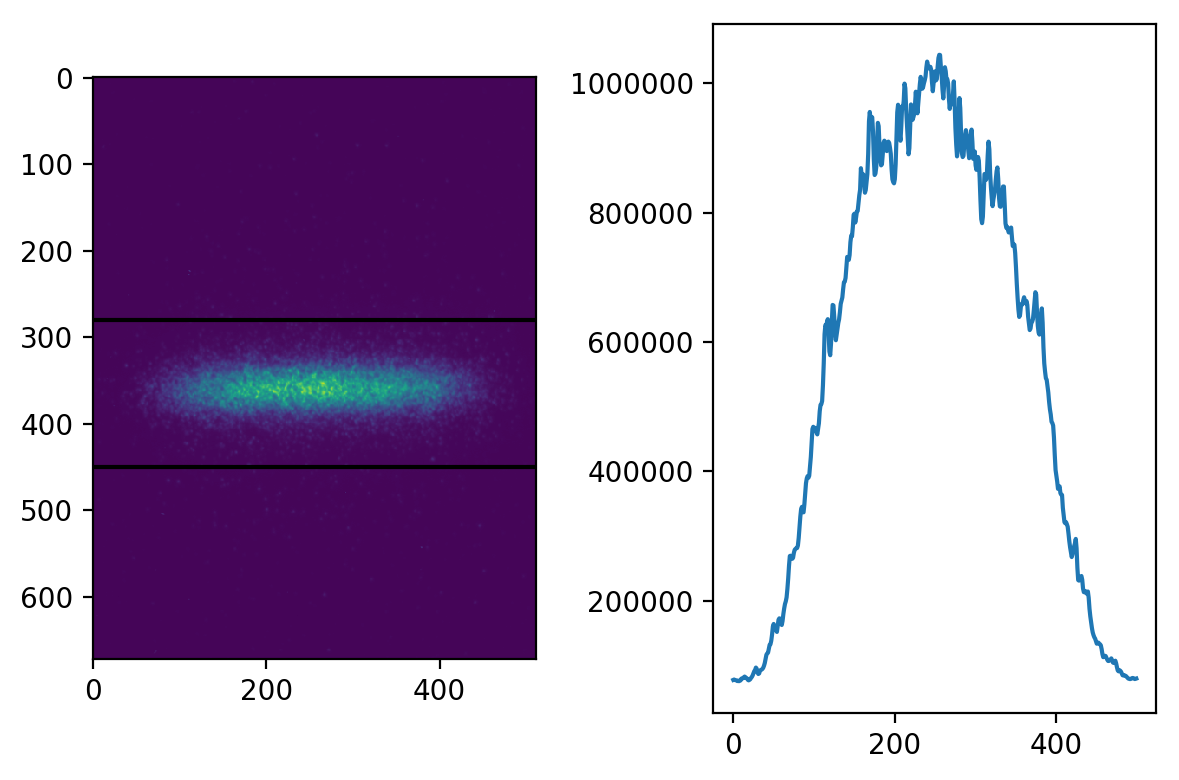

In [297]:
im = data['ScImage'].iloc[120]
# im[im>40e3] = 0.

print(im.max())

fig, ax = plt.subplots(1,2, dpi=200)
# image plot
ax[0].imshow(im, clim=(0, 30e3))
# c = ax[0].colorbar()

# plt.axvline(x = 150, color='k')
# plt.axvline(x = 511, color='k')
ax[0].axhline(y = 280, color='k')
ax[0].axhline(y = 450, color='k')


# profile plot

 #boundaries idx
y1 = 280
y2 = 450
x1 = 10
x2 = 510
profile = np.sum(im[y1:y2, x1:x2], axis=0)

ax[1].plot(profile)


fig.tight_layout()

In [300]:
def get_longitudinal_profile(image):
    '''
    Window the image to the ROI and calculate the profile by summing.
    ROI limits are hardcoded.
    '''
    y1 = 280
    y2 = 450
    x1 = 10
    x2 = 510
    
    return np.sum(image[y1:y2, x1:x2], axis=0), (x1, x2, y1, y2)

data['Streak_profile'] = data['ScImage'].apply(lambda x: get_longitudinal_profile(x))

Text(0, 0.5, 'Intensity (arb.u.)')

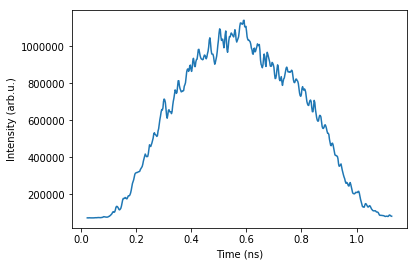

In [317]:
xx = data['SCtimeAxis'].iloc[100][10:510]
yy = data['Streak_profile'].iloc[100]
plt.plot(1e-3*xx, yy)
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (arb.u.)')

1070764.1471945536


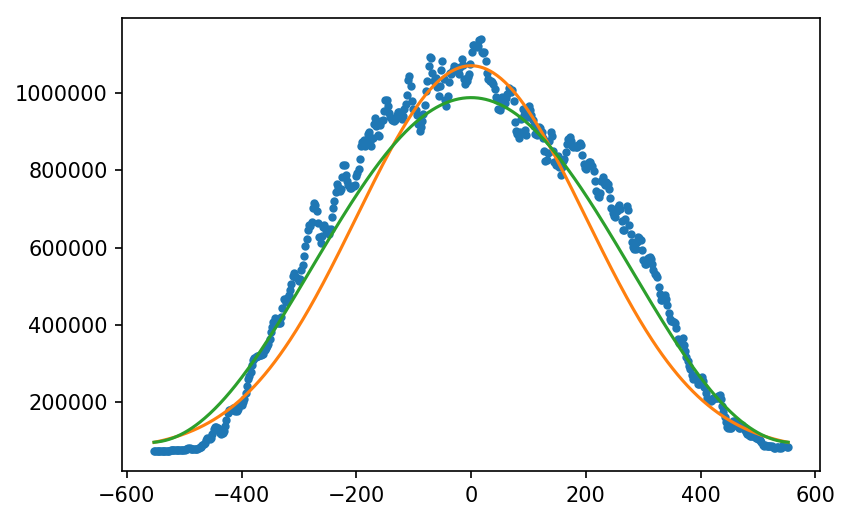

In [340]:
# rough manual fit of the curves
xx = data['SCtimeAxis'].iloc[100][10:510] - np.mean(data['SCtimeAxis'].iloc[100][10:510])
yy = data['Streak_profile'].iloc[100]
plt.plot(xx, yy,'.')



N = 5e8
yy = N*gaussian_shape(xx, 0., 200) + yy.min()
print(yy.max())
plt.plot(xx, yy)

sig = 280
yy = N*cos2_shape(xx, sig) + yy.min()
plt.plot(xx, yy)

fig = plt.gcf()
fig.dpi=150

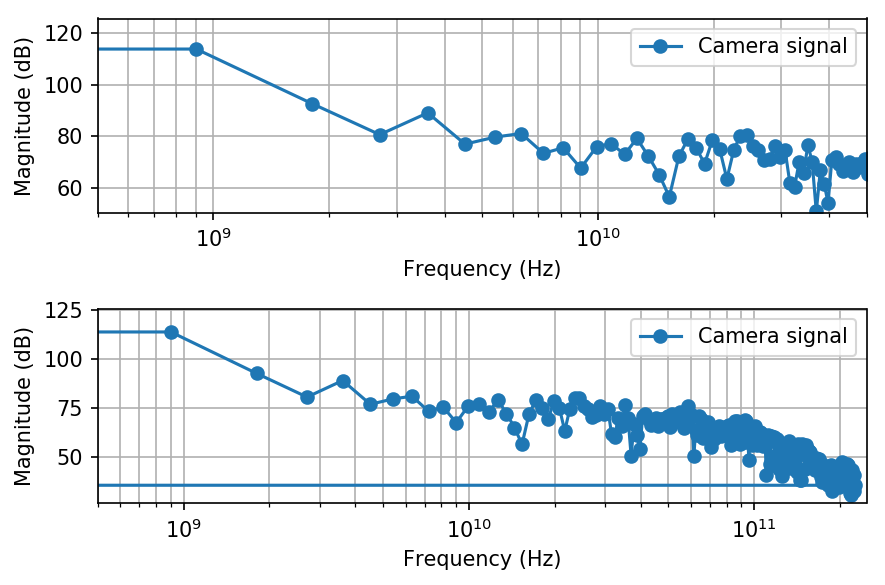

In [366]:
# FFT attempt
xx = 1e-12*data['SCtimeAxis'].iloc[100][10:510]
yy = data['Streak_profile'].iloc[100]

x_fft, y_fft = doFFT(xx,yy)


fig, ax = plt.subplots(2, dpi=150)
ax[0].plot(x_fft, dB(y_fft),'-o',label='Camera signal')
ax[0].set_xlim(5e8, 5e10)
ax[0].set_ylim(50,)
ax[0].set_xscale('log')
ax[0].grid(which='both')
ax[0].set_ylabel('Magnitude (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend(frameon=True)

ax[1].plot(x_fft, dB(y_fft),'-o',label='Camera signal')
ax[1].set_xlim(5e8, )
# ax[1].set_ylim(50,)
ax[1].set_xscale('log')
ax[1].grid(which='both')
ax[1].set_ylabel('Magnitude (dB)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].legend(frameon=True)

fig.tight_layout()

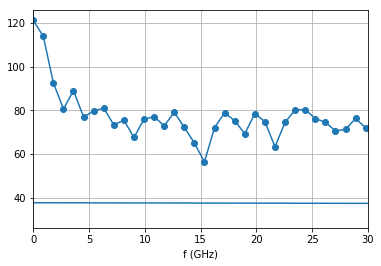

In [351]:
# FFT attempt
xx = 1e-12*data['SCtimeAxis'].iloc[100][10:510]
yy = data['Streak_profile'].iloc[100]

x_fft, y_fft = doFFT(xx,yy)

plt.plot(1e-9*x_fft,dB(y_fft),'-o')
plt.xlim(0,30)
plt.xlabel('f (GHz)')
plt.grid(which='both')


In [ ]:
TODOs:
- try to implement some filter for the camera image if necessary --> check the data
- implement a real fit routine !
- try some other fit function, for example cos(n*x), where n is a free parameter

# Particle distributions:

## Gaussian:

$$
f(x) = \frac{N e}{\sigma \sqrt{2 \pi}} e^{-\frac{(x-\mu)^2}{\sigma^2} }
$$

works fine because it is already normalised to 1, so just multiplicate for the charge to get current

## Cosine square

$$
f(x) = cos^2(\frac{\pi}{4\sigma} x), \qquad \text{for a period only} 
$$

now this is not normalised to one! So computing: $$\int_{-\frac{\pi}{2}}^\frac{\pi}{2} cos^2(x) dx = \frac{1}{2} (x+sin(x)cos(x)) = \frac{\pi}{2}$$

and so similarly 
$$\int_{-2\sigma}^{2\sigma} cos^2(\frac{\pi}{4\sigma} x) dx = \frac{x}{2} + \frac{\sigma}{4}sin(\frac{\pi}{4\sigma} x) = 2\sigma$$

so the function has to be normalised multiplying for $\frac{1}{2\sigma}$ and it is 

$$
f(x) = \frac{1}{2\sigma} cos^2(\frac{\pi}{4\sigma} x)
$$

In [319]:
def gaussian_shape(x, mu, sig):
    return 1./((sig*np.sqrt(np.pi*2))) * np.exp(-0.5*((x-mu)/sig)**2)

def current(x, N, mu, sig):
    from scipy.constants import e
    return e*N*gaussian_shape(x, mu, sig )

def dB(x):
    return 20*np.log10(x)

In [320]:
def cos2_shape(x, sigma):
    a = np.pi/(4*sigma)
    
    full_out = (1./2. / sigma)*np.cos(a*x)**2
    full_out[x<-2*sigma] = 0.
    full_out[x>2*sigma] = 0.
    
    return full_out

def cos2_current(x, N, sig):
    from scipy.constants import e
    return e*N*cos2_shape(x, sig)

In [321]:
def doFFT(t, y):
    '''
    Do the FFT. Beware there is a factor 2 in the normalisation, so look at the right-hand side of the spectrum only.
    '''
    assert t.size == y.size
    dt = np.abs(t[1]-t[0])
    N_sample = t.size
    
    norm = 2/N_sample
    
    s_fft = norm*np.abs(np.fft.fft(y))
    f_fft = np.fft.fftfreq(N_sample, d=dt)
    df = np.abs(f_fft[1]-f_fft[0])

    return f_fft, s_fft

In [322]:
def coulomb_to_N(charge):
    '''
    Total bunch charge [C] to number of particles per bunch N
    '''
    from scipy.constants import e
    return charge/e

Integral=0.9999999999990906
Integral=0.999999426710126


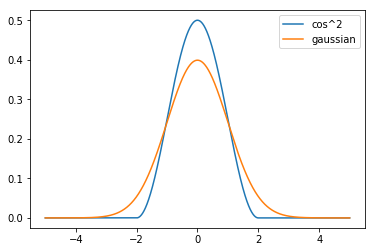

In [204]:
# distribution checks
sigma_p = 1.

tscale = np.linspace(-5*sigma_p, 5*sigma_p, 2**20)
dt = tscale[1]-tscale[0]

plt.plot(tscale, cos2_shape(tscale, sigma_p),label='cos^2')
print('Integral='+str(np.sum(cos2_shape(tscale, sigma_p)*dt)))
plt.plot(tscale, gaussian_shape(tscale, 0., sigma_p),label='gaussian')
print('Integral='+str(np.sum(gaussian_shape(tscale, 0., sigma_p)*dt)))
plt.legend(frameon=True)


# Beam distribution comparison

In [135]:
sigma_p = 0.25e-9
Np = 3e11

tscale = np.linspace(-30*sigma_p, 30*sigma_p, 2**22)

In [136]:
dt = np.abs(tscale[1]-tscale[0])
yy_p_cos2 = cos2_current(tscale, Np, sigma_p)
yy_p_gauss = current(tscale, Np, 0., sigma_p)

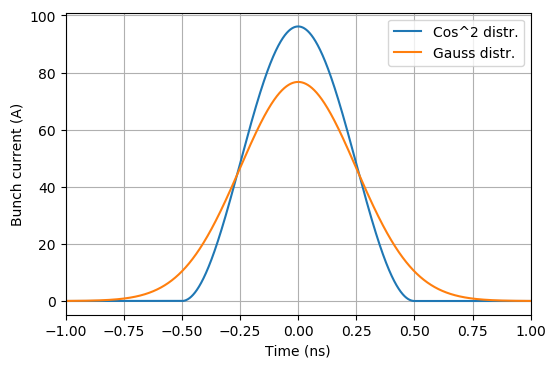

In [137]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(1e9*tscale, yy_p_cos2,label='Cos^2 distr.')
ax.plot(1e9*tscale, yy_p_gauss,label='Gauss distr.')
ax.set_xlim(-1,1)
# ax.set_ylim(-50,30)
# ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Bunch current (A)')
ax.set_xlabel('Time (ns)')
ax.legend(frameon=True)
plt.savefig('ideal_time_domain.png',format='png',dpi=300)

In [138]:
ff_p_cos2, sf_p_cos2 = doFFT(tscale,yy_p_cos2)
ff_p_gauss, sf_p_gauss = doFFT(tscale,yy_p_gauss)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


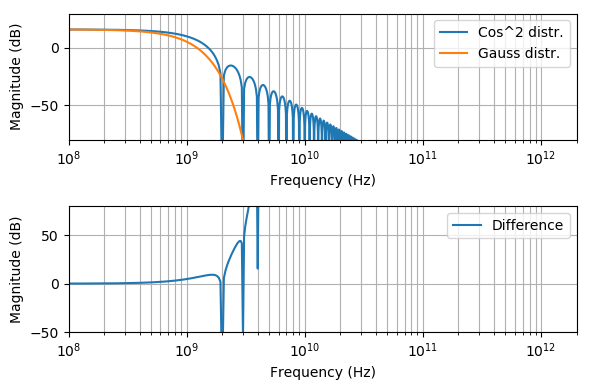

In [148]:
fig, ax = plt.subplots(2, dpi=100)
ax[0].plot(ff_p_cos2, dB(sf_p_cos2),label='Cos^2 distr.')
ax[0].plot(ff_p_gauss, dB(sf_p_gauss),label='Gauss distr.')
ax[0].set_xlim(1e8, 2e12)
ax[0].set_ylim(-80,30)
ax[0].set_xscale('log')
ax[0].grid(which='both')
ax[0].set_ylabel('Magnitude (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend(frameon=True)

ax[1].plot(ff_p_gauss, dB(sf_p_cos2) - dB(sf_p_gauss),label='Difference')
ax[1].set_xlim(1e8, 2e12)
ax[1].set_ylim(-50,80)
ax[1].set_xscale('log')
ax[1].grid(which='both')
ax[1].set_ylabel('Magnitude (dB)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].legend(frameon=True)

plt.tight_layout()
plt.savefig('ideal_freq_domain_cos2vsgauss.png',format='png',dpi=300)

# ok now with electrons also

In [169]:
sigma_p = 0.25e-9
sigma_e = 1e-12
Np = 3e11
Ne = coulomb_to_N(0.6e-9)

tscale = np.linspace(-10*sigma_p, 10*sigma_p, 2**26)

In [170]:
dt = np.abs(tscale[1]-tscale[0])
yy_p_cos2 = cos2_current(tscale, Np, sigma_p)
yy_p_gauss = current(tscale, Np, 0., sigma_p)
yy_e = current(tscale, Ne, 0., sigma_e)

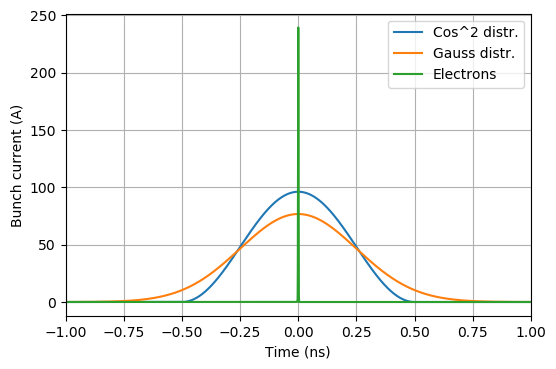

In [171]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(1e9*tscale, yy_p_cos2,label='Cos^2 distr.')
ax.plot(1e9*tscale, yy_p_gauss,label='Gauss distr.')
ax.plot(1e9*tscale, yy_e,label='Electrons')
ax.set_xlim(-1,1)
# ax.set_ylim(-50,30)
# ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Bunch current (A)')
ax.set_xlabel('Time (ns)')
ax.legend(frameon=True)
plt.savefig('ideal_time_domain.png',format='png',dpi=300)

In [172]:
ff_p_cos2, sf_p_cos2 = doFFT(tscale,yy_p_cos2)
ff_p_gauss, sf_p_gauss = doFFT(tscale,yy_p_gauss)
ff_e, sf_e = doFFT(tscale,yy_e)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


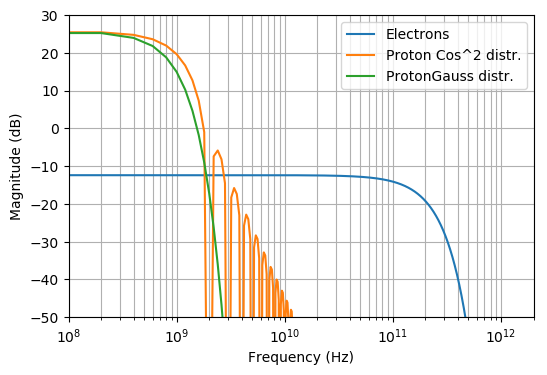

In [173]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(ff_e, dB(sf_e),label='Electrons')
ax.plot(ff_p_cos2, dB(sf_p_cos2),label='Proton Cos^2 distr.')
ax.plot(ff_p_gauss, dB(sf_p_gauss),label='ProtonGauss distr.')
ax.set_xlim(1e8, 2e12)
ax.set_ylim(-50,30)
ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency (Hz)')
ax.legend(frameon=True)
plt.savefig('ideal_freq_domain.png',format='png',dpi=300)